In [1]:
%load_ext autoreload 
%autoreload 2
import regtricks as rt 
import multiprocessing as mp 
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from pdb import set_trace
from scipy.spatial.transform import Rotation
from pvec_functions import * 
from fabber_funcs import get_fabber_data, run_basil, MODEL_OPTIONS, PARAMS
from functools import partial 
np.random.seed(1)

## Real test case: an HCP subject

We use the anatomical data from HCP subject 100318, for which the T1 images were acquired at 0.7mm isotropic. All CBF data is simulated, again using constant CBF in GM/WM, at a resolution of 3mm isotropic. PVs were previously estimated at both resolutions using FreeSurfer, FIRST and Toblerone, *without interpolation*, and the 0.7mm estimates are taken to be of sufficiently high resolution that they are close enough to ground truth. For this demo, the question of ground truth is actually irrelevant, as we generate CBF data with PVE from any arbitrary PV estimates. 

In [28]:
asl_spc = rt.ImageSpace('tob_all_stacked_3.0.nii.gz')
t1_spc = rt.ImageSpace('tob_all_stacked_0.7.nii.gz')
pvs = nibabel.load('tob_all_stacked_3.0.nii.gz').get_fdata()[...,:2]
pvs_high = nibabel.load('tob_all_stacked_0.7.nii.gz').get_fdata()[...,:2]
mid_slice = asl_spc.size[-1] // 2
mid_slice_high = t1_spc.size[-1] // 2
make_mask = lambda a: (a > 0.02).all(-1)
make_bmask = lambda a: (a > 0.02).any(-1)
mask = make_mask(pvs)
brain_mask = make_bmask(pvs)
def get_fig(size=(15,5), dpi=100, **kwargs): 
    return plt.figure(figsize=size, dpi=dpi, **kwargs)

In [3]:
CBF = [60, 20]
BAT = [1.3, 1.6]

## PVEc of ASL data without any resampling

This simply demonstrates the point that in the absence of any confounding effects, you can perfectly recover ground truth. 

In [30]:
asl = get_fabber_data(CBF, BAT, pvs, MODEL_OPTIONS)  
cbf_pvec = run_basil(asl, brain_mask, MODEL_OPTIONS, pvs)

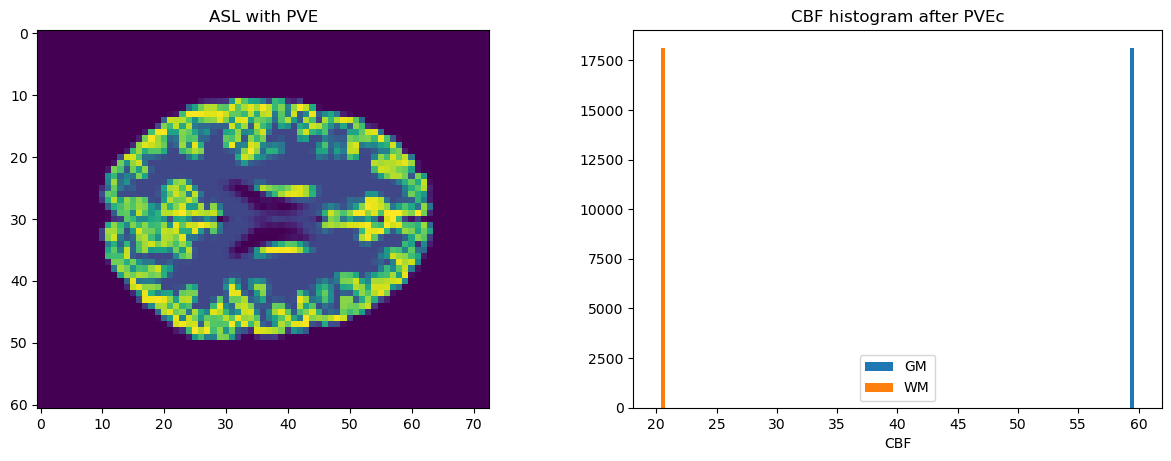

Means (GM, WM): 58.05261670122797 19.34956181362798
Std devs (GM, WM): 10.632610139129682 3.54396337011681
Std devs (GM, WM): 60.00004196166992 20.000064849853516


In [31]:
fig = get_fig()
bin_edges = np.arange(10,80)
plt.subplot(1,2,1)
plt.imshow(asl[...,mid_slice,0])
plt.title('ASL with PVE')
plt.subplot(1,2,2)
plt.hist(cbf_pvec[mask], 50);
plt.title('CBF histogram after PVEc')
plt.legend(['GM', 'WM']); plt.xlabel('CBF')
plt.show()
print("Means (GM, WM):", cbf_pvec[mask_trans,0].mean(), cbf_pvec[mask_trans,1].mean())
print("Std devs (GM, WM):", cbf_pvec[mask_trans,0].std(), cbf_pvec[mask_trans,1].std())
print("Std devs (GM, WM):", cbf_pvec[mask_trans,0].max(), cbf_pvec[mask_trans,1].max())

### PVEc on resampled ASL data and resampled PV estimates

Both the ASL and the PV estimates undergo the same transformation. The simulations on the spherical test case suggest this is the 'best' approach if resampling is necessary, aka the 'double-resampled' approach.

In [7]:
rot1 = Rotation.from_euler('z', 5, degrees=True)
rot2 = Rotation.from_euler('x', 3, degrees=True)
transform = np.eye(4)
transform[:3,:3] = (rot1.as_matrix() @ rot2.as_matrix())
transform[:3,3] = 6 * np.random.rand(3)
transform = rt.Registration(transform)
transform

Registration (linear) with properties:
src2ref:       [   0.996   -0.087    0.005    2.502]
               [   0.087    0.995   -0.052    4.322]
               [   0.000    0.052    0.999    0.001]
               [   0.000    0.000    0.000    1.000]

In [8]:
asl_trans = transform.apply_to_array(asl, asl_spc, asl_spc, order=1)
pv_trans = transform.apply_to_array(pvs_high, t1_spc, asl_spc, order=1)
bmask_trans = make_bmask(pv_trans)
cbf_pvec_trans = run_basil(asl_trans, make_bmask(pv_trans), MODEL_OPTIONS, pv_trans)

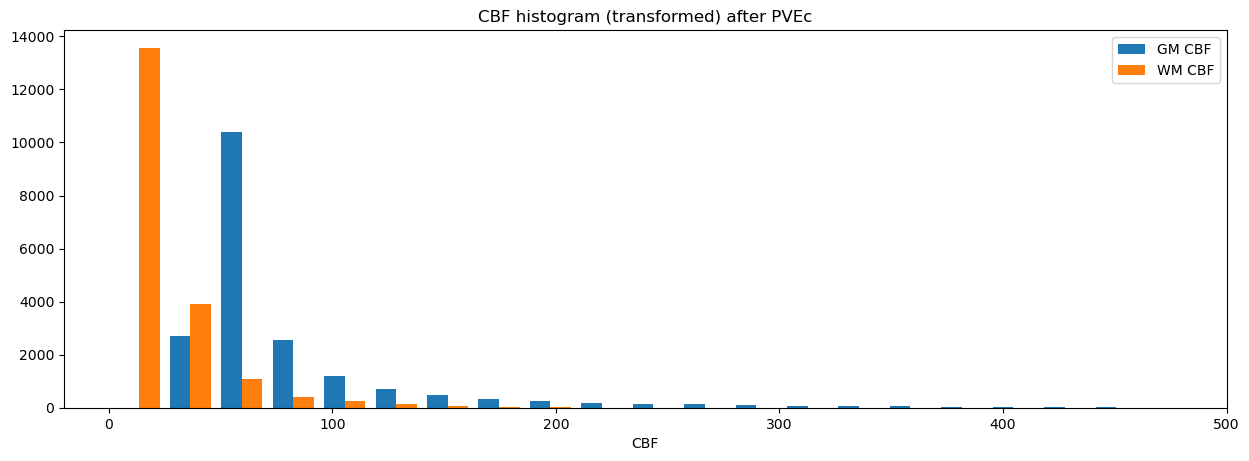

Means (GM, WM): 80.34846430112995 28.036159574339624
Std devs (GM, WM): 59.01414374075727 44.37283748236978
Max (GM, WM): 1132.2349853515625 4441.509765625


In [26]:
fig = get_fig()
mask_trans = make_mask(pv_trans)
# plt.subplot(1,3,1)
# plt.hist(cbf[mask], bin_edges)
# plt.title('CBF histogram (original space)'); plt.xlabel('CBF')
# plt.subplot(1,3,2)
# plt.hist(cbf_trans[mask_trans], bin_edges)
# plt.xlabel('CBF'); plt.title('CBF histogram (transformed), before PVEc')
# plt.subplot(1,3,3)
plt.hist(cbf_pvec_trans[mask_trans], 200); plt.xlim(-20,500)
plt.xlabel('CBF'); plt.title('CBF histogram (transformed) after PVEc')
plt.legend(['GM CBF', 'WM CBF'])
plt.show()
print("Means (GM, WM):", cbf_pvec_trans[mask_trans,0].mean(), cbf_pvec_trans[mask_trans,1].mean())
print("Std devs (GM, WM):", cbf_pvec_trans[mask_trans,0].std(), cbf_pvec_trans[mask_trans,1].std())
print("Max (GM, WM):", cbf_pvec_trans[mask_trans,0].max(), cbf_pvec_trans[mask_trans,1].max())

Due to the presence of large positive outliers, the class means for both tissues get dragged up from their ground truth values. 

### PVEc on resampled ASL data, un-resampled PV estimates

This is the situation with a common analysis space, where all ASL data is transformed onto the same template (for example, the T1 image). This means there is a single global PV map that is used for PVEc of all ASL repeats. This performs worse than the double-resampled case. 

In [21]:
asl_trans = get_fabber_data(CBF, BAT, pv_trans, MODEL_OPTIONS)  
asl_trans_native = transform.inverse().apply_to_array(asl_trans, asl_spc, asl_spc, order=1)
cbf_pvec_native_trans = run_basil(asl_trans_native, make_bmask(pvs), MODEL_OPTIONS, pvs)

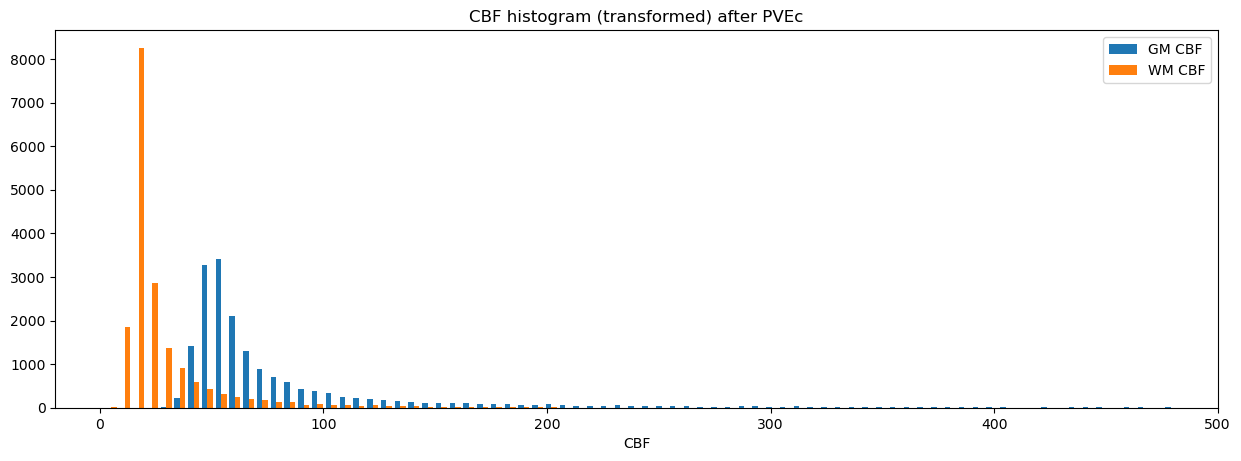

Means (GM, WM): 107.95016912195369 67943.6831542013
Std devs (GM, WM): 259.11312192456944 274979.28474578983
Max (GM, WM): 2911.5966796875 10915065.0


In [27]:
fig = get_fig()
# plt.subplot(1,3,1)
# plt.hist(asl_trans[mask_trans], bin_edges)
# plt.title('CBF histogram (original space)'); plt.xlabel('CBF')
# plt.subplot(1,3,2)
# plt.hist(cbf_trans[mask_trans], bin_edges)
# plt.xlabel('CBF'); plt.title('CBF histogram (transformed), before PVEc')
# plt.subplot(1,3,3)
plt.hist(cbf_pvec_native_trans[mask], 200); plt.xlim(-20,500)
plt.xlabel('CBF'); plt.title('CBF histogram (transformed) after PVEc')
plt.legend(['GM CBF', 'WM CBF'])
plt.show()
print("Means (GM, WM):", cbf_pvec_native_trans[mask_trans,0].mean(), cbf_pvec_native_trans[mask_trans,1].mean())
print("Std devs (GM, WM):", cbf_pvec_native_trans[mask_trans,0].std(), cbf_pvec_native_trans[mask_trans,1].std())
print("Max (GM, WM):", cbf_pvec_native_trans[mask_trans,0].max(), cbf_pvec_native_trans[mask_trans,1].max())

Note that the range of values is worse than the previous case, especially for WM (such that it drags up the mean for that entire class)

## Don't go beyond this point!

### How much of a problem are PVE for repeatability analysis anyway? Repeats with constant CBF. 

Simulate the Maastricht dataset I've been working with: 4 repeat acquisitions. Generate a random transform and apply that to the T1 PVs to get ASL space PV maps, each in their own individual space. Generate CBF maps off each of them, and then apply the reverse transform back into alignment with the original T1 image and calculate CoV. 

Each transformation will be a rotation in the xy plane of [0,10] degrees and an xy translation in the range [0,10] mm. 

To start with, asssume constant CBF in GM and WM. 

In [47]:
RPTS = 4
transforms = []
for _ in range(RPTS):
    rot1 = Rotation.from_euler('z', np.random.randint(0,6), degrees=True)
    rot2 = Rotation.from_euler('y', np.random.randint(0,6), degrees=True)
    transform = np.eye(4)
    transform[:3,:3] = (rot1.as_matrix() @ rot2.as_matrix())
    transform[:3,3] = 10 * (np.random.rand(3))
    transform = rt.Registration(transform)
    transforms.append(transform)

In [48]:
def worker(transform):
    pv_native = transform.apply_to_array(pvs_high, t1_spc, asl_spc, cores=1)
    asl_native = get_fabber_data(CBF, BAT, pv_native, MODEL_OPTIONS) 
    asl_common = transform.inverse().apply_to_array(asl_native, asl_spc, asl_spc, order=1, cores=1)
    pv_double = transform.inverse().apply_to_array(pv_native, asl_spc, asl_spc, cores=1)
    cbf_common = run_basil(asl_common, brain_mask, MODEL_OPTIONS)
    cbf_common_pvec_naive = run_basil(asl_common, brain_mask, MODEL_OPTIONS, pvs) 
    cbf_common_pvec_double = run_basil(asl_common, brain_mask, MODEL_OPTIONS, pv_double) 
    return cbf_common, cbf_common_pvec_naive, cbf_common_pvec_double

# with mp.Pool() as p: 
#     results = p.map(worker, transforms)
results = [ worker(t) for t in transforms ]

KeyboardInterrupt: 

In [60]:
transform = transforms[0]
pv_native = transform.apply_to_array(pvs_high, t1_spc, asl_spc, cores=1)
asl_native = get_fabber_data(CBF, BAT, pv_native, MODEL_OPTIONS) 
asl_common = transform.inverse().apply_to_array(asl_native, asl_spc, asl_spc, order=1, cores=1)
pv_double = transform.inverse().apply_to_array(pv_native, asl_spc, asl_spc, cores=1)
# run_basil(asl_common, brain_mask, MODEL_OPTIONS, pv_double) 

array([[[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
   

In [53]:
cbf_repeats_common = np.stack([ r[0] for r in results ], axis=-1)
cbf_pvec_repeats_naive = np.stack([ r[1][...,0] for r in results ], axis=-1)
cbf_pvec_repeats_double = np.stack([ r[2][...,0] for r in results ], axis=-1)
masks_native = np.stack([ r[0].astype(np.bool) for r in results ], axis=-1)

Display each raw CBF map on the top row, and then the transformed CBF map in the common-aligned analysis space on the bottom row. 

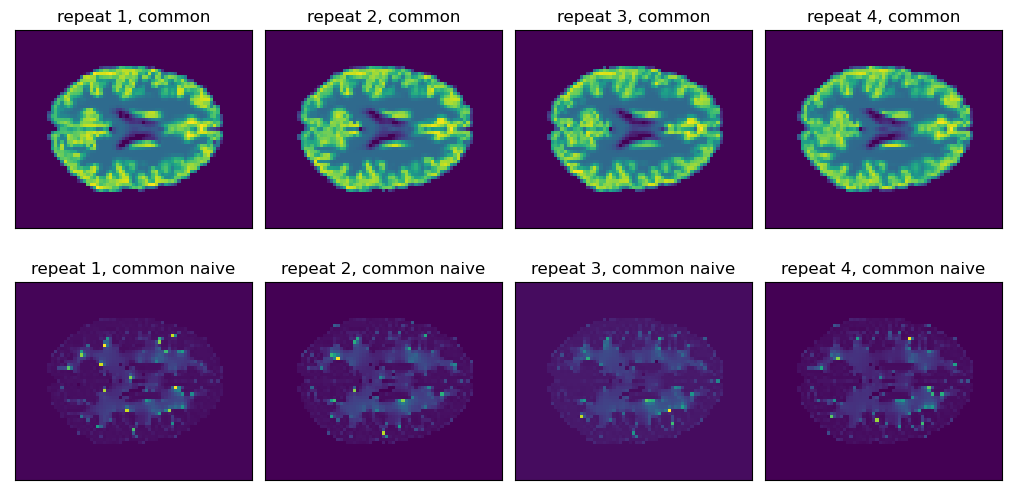

In [54]:
fig = get_fig(size=(10,5), constrained_layout=True)
for r in range(RPTS):
    plt.subplot(2,RPTS,r+1)
    plt.imshow(cbf_repeats_common[:,:,mid_slice,r])
    plt.xticks([]); plt.yticks([])
    plt.title(f'repeat {r+1}, common')
    plt.subplot(2,RPTS,r+5)
    plt.imshow(cbf_pvec_repeats_naive[:,:,mid_slice,r])
    plt.title(f'repeat {r+1}, common naive')
    plt.xticks([]); plt.yticks([])

Calculate the CoV in PVE voxels across the repeats in the common aligned space. Perform PVEc on each transformed repeat in the common aligned space, using the single map of PV estimates that we previously obtained, and calculate the CoV across repeats in PVEc CBF. 

In [55]:
calc_cov = lambda a: 100 * np.abs(a.std(-1) / a.mean(-1))
cbf_rpts_cov = calc_cov(cbf_repeats_common[mask,:])
cbf_rpts_pvec_naive_cov = calc_cov(cbf_pvec_repeats_naive[mask,:])
cbf_rpts_pvec_double_cov = calc_cov(cbf_pvec_repeats_double[mask,:])
# cbf_rpts_pvec_cov_wm = calc_cov(cbf_pvec_repeats_commmon[mask,1,:])

Plot voxel-wise CoV in CBF before PVEc, and after PVEc, in each tissue separately. As can be seen, there is a general reduction in GM CoV after performing PVEc, but compared to the case of no PVEc, it would be hard to argue that a major reduction has been obtained. The CoV in WM CBF after PVEc is actually increased compared to no PVEc, probably due to GM signal been allocated to the WM class and therefore dragging up individual voxel CBF values, thereby increasing CoV. In summary, for this highly artificial test case of constant CBF, and using a PVEc method that also assumes constant CBF, PVEc cannot be said to dramatically reduce voxel-wise CoV. 

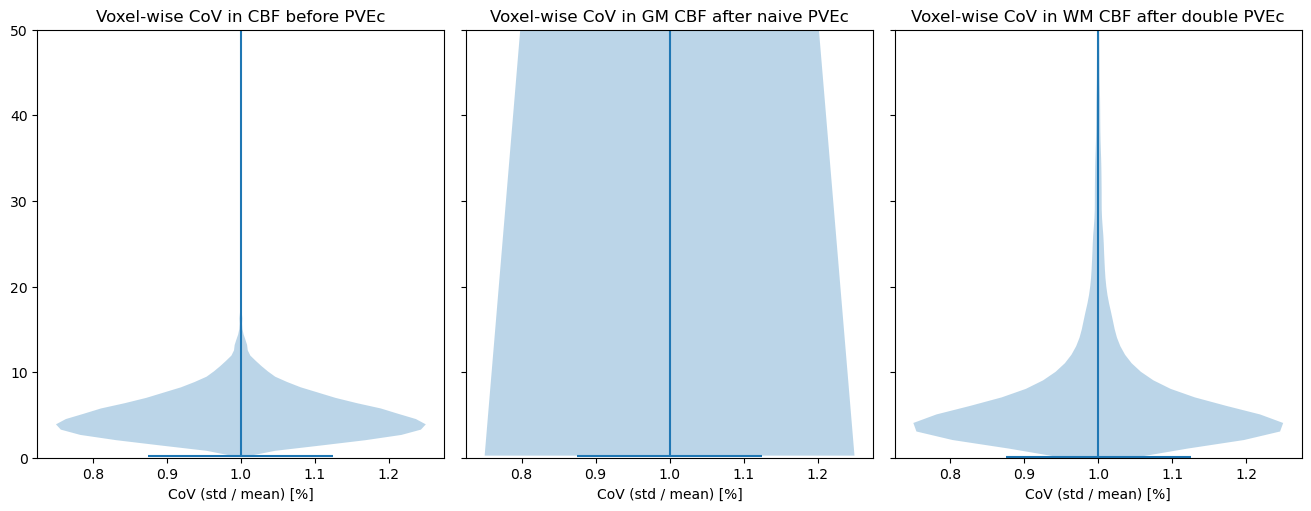

In [57]:
fig, axes = plt.subplots(1,3, sharey=True, constrained_layout=True, dpi=100)
fig.set_size_inches(13,5)
bins = np.linspace(0,40)
axes[0].violinplot(cbf_rpts_cov); axes[0].set_ylim(0,50)
axes[0].set_title('Voxel-wise CoV in CBF before PVEc'); axes[0].set_xlabel('CoV (std / mean) [%]')
axes[1].violinplot(cbf_rpts_pvec_naive_cov)
axes[1].set_title('Voxel-wise CoV in GM CBF after naive PVEc'); axes[1].set_xlabel('CoV (std / mean) [%]')
axes[2].violinplot(cbf_rpts_pvec_double_cov)
axes[2].set_title('Voxel-wise CoV in WM CBF after double PVEc'); axes[2].set_xlabel('CoV (std / mean) [%]')
plt.show()

### Repeats with noise

Now consider non-constant CBF, namely normally distributed GM and WM CBF. Repeat the entire process: generate CBF maps, transform them into common aligned space, measure CoV before and after PVEc. We use the same set of transforms as before. 

In [ ]:
def worker(transform):
    pv_native = transform.apply_to_array(pvs_high, t1_spc, asl_spc, cores=1)
    asl_native = get_fabber_data(CBF, BAT, pv_native, MODEL_OPTIONS) 
    asl_native += np.random.normal(0, 4, size=asl_native.shape)
    asl_common = transform.inverse().apply_to_array(asl_native, asl_spc, asl_spc, order=1, cores=1)
    pv_double = transform.inverse().apply_to_array(pv_native, asl_spc, asl_spc, cores=1)
    cbf_common = run_basil(asl_common, brain_mask, MODEL_OPTIONS)
    cbf_common_pvec_naive = run_basil(asl_common, brain_mask, MODEL_OPTIONS, pvs) 
    cbf_common_pvec_double = run_basil(asl_common, brain_mask, MODEL_OPTIONS, pv_double) 
    return cbf_common, cbf_common_pvec_naive, cbf_common_pvec_double

# with mp.Pool() as p: 
#     results = p.map(worker, transforms)
results = [ worker(t) for t in transforms ]

In [ ]:
cbf_repeats_common = np.stack([ r[0] for r in results ], axis=-1)
cbf_pvec_repeats_naive = np.stack([ r[1] for r in results ], axis=-1)
cbf_pvec_repeats_double = np.stack([ r[2] for r in results ], axis=-1)
masks_native = np.stack([ r[0].astype(np.bool) for r in results ], axis=-1)

In [ ]:
calc_cov = lambda a: 100 * np.abs(a.std(-1) / a.mean(-1))
cbf_rpts_cov = calc_cov(cbf_repeats_common[mask,:])
cbf_rpts_pvec_naive_cov = calc_cov(cbf_pvec_repeats_naive[mask,0,:])
cbf_rpts_pvec_double_cov = calc_cov(cbf_pvec_repeats_double[mask,0,:])
# cbf_rpts_pvec_cov_wm = calc_cov(cbf_pvec_repeats_commmon[mask,1,:])

Plot the raw CBF maps (top row) and the transformed maps in common-aligned space (bottom row). 

Calculate CoV across runs before and after PVEc

In [ ]:
fig, axes = plt.subplots(1,3, sharey=True, constrained_layout=True, dpi=100)
fig.set_size_inches(13,5)
bins = np.linspace(0,40)
axes[0].violinplot(cbf_rpts_cov); axes[0].set_ylim(0,30)
axes[0].set_title('Voxel-wise CoV in CBF before PVEc'); axes[0].set_xlabel('CoV (std / mean) [%]')
axes[1].violinplot(cbf_rpts_pvec_naive_cov)
axes[1].set_title('Voxel-wise CoV in GM CBF after naive PVEc'); axes[1].set_xlabel('CoV (std / mean) [%]')
axes[2].violinplot(cbf_rpts_pvec_double_cov)
axes[2].set_title('Voxel-wise CoV in WM CBF after double PVEc'); axes[2].set_xlabel('CoV (std / mean) [%]')
plt.show()